In [1]:
# coding: utf-8
import numpy as np
import pandas as pd

import random
import math

pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

In [131]:
def elo_prob(rw=1600, rb=1600):
    """
    base elo propability without chancging k for newcommets etc.
    """
    rw = float(rw)
    rb = float(rb)
    res = 1 / (1 + np.power(10, (rb-rw) / 400))
    return res

def get_match(rating1=1600, rating2=1600, total=0, sigma=2.5):
    """ 
    get match result according elo rating, total scores and sigma of probability distribution
    """
    # import random
    # import math
    # base probability
    # based on 100 elo meand approximately win on 1 goal (1-0, 2-1 etc.)
    norn_factor = 15
    mult_factor = 100
    mu = mult_factor * (elo_prob(rating1, rating2) - 0.5) / norn_factor

    # current different between teams in this proba
    base_res = round(random.normalvariate(mu, sigma), 0)

    # scores from total and diffs
    if base_res > 0:
        res2 = total
        res1 = total + base_res
    else:
        res1 = total
        res2 = total - base_res


    return int(res1), int(res2)


def get_round_robin_schedule(teams:list, num_cycles=2):
    """ 
    get round robin schedule for teams
    """ 
    if len(teams) % 2 != 0:
        teams.append(None)
    
    num_rounds = len(teams) - 1
    schedule = []
    
    for cycle in range(num_cycles):
        matches = []
        for round in range(num_rounds):
            for i in range(len(teams)//2):
                if teams[i] is None or teams[len(teams)-1-i] is None:
                    continue

                matches.append((teams[i], teams[len(teams)-1-i]))
            
            teams = [teams[0]] + [teams[-1]] + teams[1:len(teams)-1]
        
        if cycle != 0:
            invert_m = []
            for m in matches:
                invert_m.append((m[1], m[0]))
            matches = invert_m
        
        schedule.append(matches)
    
    return schedule

def get_roudn_robin_match_results(teams_dct, num_cycles=2):
    """
    get round robin match results for teams
    """
    # import random
    
    teams_lst = list(teams_dct.keys())
    round_robin_schedule_lst = get_round_robin_schedule(teams_lst, num_cycles)

    id1 = []
    id2 = []
    team1 = []
    team2 = []
    sc1 = []
    sc2 = []
    for round in round_robin_schedule_lst:
        for pair in round:
            total = np.round(random.uniform(0, 3),0)
            sigma = np.round(random.uniform(2, 3),2)
            res = get_match(
                        teams_dct[pair[0]][1], 
                        teams_dct[pair[1]][1],
                        total, sigma
                            )
            id1.append(pair[0])
            id2.append(pair[1])
            team1.append(teams_dct[pair[0]][0])
            team2.append(teams_dct[pair[1]][0])
            sc1.append(res[0])
            sc2.append(res[1])
    res_df = pd.DataFrame([id1, id2, team1, team2, sc1, sc2]).T
    res_df.columns = ['id1', 'id2', 'team1', 'team2', 'score1', 'score2']

    return res_df

def get_round_robin_table(teams_dct, total=0, sigma=2.5, num_cycles=2):
    """
    get round robin tournament table for teams
    """

    res_df = get_roudn_robin_match_results(teams_dct, num_cycles)
    res_df['points1'] = np.where(
        res_df['score1'] > res_df['score2'], 3,
        np.where(res_df['score1'] < res_df['score2'], 0, 1)
                                )
    res_df['points2'] = np.where(
        res_df['score1'] > res_df['score2'], 0,
        np.where(res_df['score1'] < res_df['score2'], 3, 1)
                                )
    
    res_df['games'] = 1
    
    tournament_results_df_home = res_df.groupby(['id1', 'team1']).agg(
                        {'score1': 'sum', 'points1': 'sum', 'games': 'sum'}
                                                                ).reset_index()
    tournament_results_df_away = res_df.groupby(['id2', 'team2']).agg(
                        {'score2': 'sum', 'points2': 'sum', 'games': 'sum'}
                                                                ).reset_index()
    tournament_results_df_home.columns = ['id', 'team', 'score', 'points', 'games']
    tournament_results_df_away.columns = ['id', 'team', 'score', 'points', 'games']

    
    tournament_results_df = tournament_results_df_home.merge(tournament_results_df_away, 'left', on=['id'], suffixes=['_home', '_away'])
    tournament_results_df['points'] = tournament_results_df['points_home'] + tournament_results_df['points_away']
    tournament_results_df['scored'] = tournament_results_df['score_home'] + tournament_results_df['score_away']
    tournament_results_df['games'] = tournament_results_df['games_home'] + tournament_results_df['games_away']

    tournament_results_df = tournament_results_df.sort_values(by=['points', 'scored'], ascending=False)

    tournament_results_df = tournament_results_df.rename(columns={'team_home': 'team'})

    tournament_results_df['rating'] = tournament_results_df['id'].map(teams_dct).apply(lambda x: x[1])
    tournament_results_df['criteria'] = tournament_results_df['points'] * 1000 + tournament_results_df['scored']
    tournament_results_df['place'] = tournament_results_df['criteria'].rank(method='min', ascending=False).astype(int)

    tournament_results_df = tournament_results_df[[
        'place', 'team', 'rating', 'games', 'points', 'scored', 'points_home', 'score_home', 'games_home', 'points_away', 'score_away', 'games_away'
    ]]
    
    return tournament_results_df, res_df

def get_round_robin_simulation(teams_dct, num_cycles=2, n_iters=1000):
    """
    get full simulation in n_iters iteration to know the best results and metrics
    """
    tournament_results_df = pd.DataFrame()
    res_df = pd.DataFrame()
    for iter in range(n_iters):
        tournament_results_df_iter, res_df_iter = get_round_robin_table(teams_dct)
        tournament_results_df_iter['iteration_id'] = iter
        res_df_iter['iteration_id'] = iter
        tournament_results_df = pd.concat([tournament_results_df, tournament_results_df_iter])
        res_df = pd.concat([res_df, res_df_iter])

    multiverse_stat = tournament_results_df.groupby(['team', 'place', 'rating']).agg(
        times = ('games', 'count'),
        points = ('points', 'mean'),
        scored = ('scored', 'mean'),
        games = ('games', 'mean'),
                                                        ).reset_index()
    
    multiverse_stat['goals_per_game'] = np.round(multiverse_stat['scored'] / multiverse_stat['games'], 2)
    multiverse_stat['points'] = np.round(multiverse_stat['points'], 1)
    multiverse_stat['scored'] = np.round(multiverse_stat['scored'], 1)

    multiverse_stat.drop(columns=['games'], inplace=True)
    multiverse_stat = multiverse_stat.sort_values(by=['place', 'times'], ascending=[True, False])

    return multiverse_stat

def print_multiverse_heat_map(multiverse_stat, filed, normalize=1):
    """
    print multiverse heat map
    """

    multiverse_pivot = multiverse_stat.pivot_table(
        index=['team', 'rating'], columns=filed, values='times', fill_value=0
                                                )#.reset_index()
    multiverse_pivot = multiverse_pivot.sort_values(by=['rating'], ascending=False)
    multiverse_pivot = multiverse_pivot / normalize

    import seaborn as sns
    sns.heatmap(multiverse_pivot, annot=True, fmt=".0f", cmap="crest")#, vmin=0, vmax=1)

    return  multiverse_pivot


In [66]:
# small example teamset
# 4 pairs of teams with approximately same rating
# with huge gap between each other
teams_dct = {
    1: ['Barcelona', 2630, 1],
    2: ['Real Madrid', 2600, 1],
    3: ['Osasuna', 2420, 1],
    4: ['Espanyol', 2330, 1],
    5: ['Tenerife', 1800, 1],
    6: ['Zaragoza', 1750, 1],
    7: ['Ronaldo fun club', 1280, 1],
    8: ['Messi fun club', 1200, 1],
            }

In [55]:
get_match(1000, 900, 0, 2.5)

(0, 0)

In [75]:
tournament_results_df, res_df = get_round_robin_table(teams_dct)
tournament_results_df

,place,team,rating,games,points,scored,points_home,score_home,games_home,points_away,score_away,games_away
0,1,Barcelona,2630,14,34,52,18,30,7,16,22,7
3,2,Espanyol,2330,14,33,67,15,33,7,18,34,7
1,3,Real Madrid,2600,14,33,44,18,24,7,15,20,7
2,4,Osasuna,2420,14,22,58,10,30,7,12,28,7
4,5,Tenerife,1800,14,15,34,9,16,7,6,18,7
6,6,Ronaldo fun club,1280,14,13,28,7,14,7,6,14,7
5,7,Zaragoza,1750,14,11,26,7,11,7,4,15,7
7,8,Messi fun club,1200,14,4,30,0,14,7,4,16,7


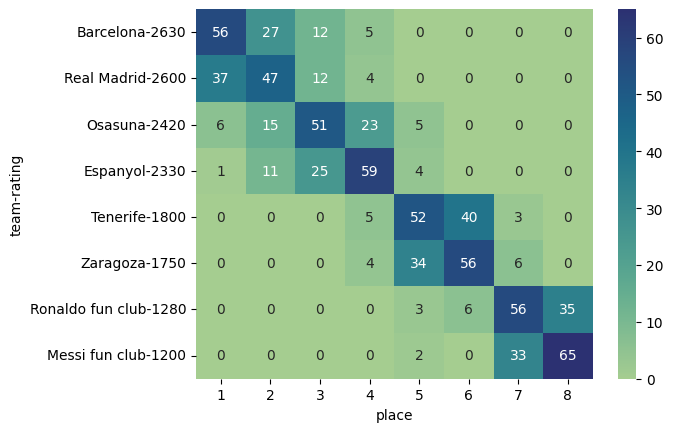

In [132]:
n_iters = 100
multiverse_stat = get_round_robin_simulation(teams_dct, n_iters=n_iters)
multiverse_pivot = print_multiverse_heat_map(multiverse_stat, 'place', normalize=1)

In [133]:
multiverse_stat

,team,place,rating,times,points,scored,goals_per_game
0,Barcelona,1,2630,56,36.3,63.8,4.55
17,Real Madrid,1,2600,37,35.8,60.3,4.31
12,Osasuna,1,2420,6,31.8,50.5,3.61
4,Espanyol,1,2330,1,33.0,59.0,4.21
18,Real Madrid,2,2600,47,32.8,60.2,4.30
1,Barcelona,2,2630,27,32.1,58.0,4.14
13,Osasuna,2,2420,15,31.8,57.5,4.11
5,Espanyol,2,2330,11,30.5,55.5,3.97
14,Osasuna,3,2420,51,27.8,51.5,3.68
6,Espanyol,3,2330,25,27.1,51.2,3.66
